### Load the Data and Save Files in the ```data``` directory

In [1]:
from datasets import load_dataset
from pathlib import Path

In [2]:
dataset = load_dataset(path="4DR1455/finance_questions", split="train")

# select the first 5000 docs
dataset_small = dataset.select(range(500))

Path("data_finance").mkdir(parents=True, exist_ok=True)
for i, finance_doc in enumerate(dataset_small):
    with open(Path("data_finance") / f"finance_{i}.txt", "w") as f:
        f.write(finance_doc["output"])

In [3]:
from llama_index.core import SimpleDirectoryReader

reader = SimpleDirectoryReader(input_dir="data_finance")
documents = reader.load_data()
len(documents)

500

### Store and Index the Embedded Documents in ``Chroma DB``

Using `PersistentClient` allows us to save the data to a local path and ensures that the data remains accessible across sessions. With this approachwe can embed Chroma directly within our application.

In [6]:
import chromadb
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.embeddings.huggingface_api import HuggingFaceInferenceAPIEmbedding
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.ingestion import IngestionPipeline
from llama_index.embeddings import huggingface_api

db = chromadb.PersistentClient(path="./chroma_db")
chroma_collection = db.get_or_create_collection(name="finance")
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)

pipeline = IngestionPipeline(
    transformations=[
        SentenceSplitter(chunk_size=500,
                        chunk_overlap=50),
        HuggingFaceInferenceAPIEmbedding(model_name="BAAI/bge-small-en-v1.5"),
    ],
    vector_store=vector_store,
)

nodes = await pipeline.arun(documents=documents)
len(nodes)

904

In [7]:
from llama_index.core import VectorStoreIndex
from llama_index.embeddings.huggingface_api import HuggingFaceInferenceAPIEmbedding

embed_model = HuggingFaceInferenceAPIEmbedding(model_name="BAAI/bge-small-en-v1.5")
index = VectorStoreIndex.from_vector_store(
    vector_store=vector_store, embed_model=embed_model
)

### Query the Index

In [8]:
from llama_index.llms.huggingface_api import HuggingFaceInferenceAPI
import nest_asyncio

nest_asyncio.apply()  # This is needed to run the query engine
llm = HuggingFaceInferenceAPI(model_name="Qwen/Qwen2.5-Coder-32B-Instruct")
query_engine = index.as_query_engine(
    llm=llm,
    similarity_top_k=3
    #response_mode="tree_summarize",
)
response = query_engine.query(
    "credit migration"
)

### Analyze the Response and Retrieved Documents

In [38]:
print(f'Response: \n{response.response}')

Response: 
Credit migration strategy is a method used in credit risk management that focuses on the changes in credit quality of bonds or bond issuers over time. This strategy involves monitoring credit ratings and adjusting the portfolio accordingly to manage risks and take advantage of opportunities. It can be employed to manage interest rate risk through diversification, hedging with credit derivatives, active management, and duration management.


In [19]:
for node in response.source_nodes:
     print('Text:', node.metadata['file_name'], ', score:', round(node.score, 3), node.text[:100], '\n')

Text: finance_53.txt , score: 0.651 By shifting the portfolio towards these bonds when interest rates are expected to rise, the manager  

Text: finance_53.txt , score: 0.647 Credit migration strategy is a type of credit risk management strategy that focuses on the changes i 

Text: finance_244.txt , score: 0.586 However, a low ratio may also indicate that the company is effectively utilizing trade credit terms  



### QueryEngine as a Tool for An Agent

In [21]:
from llama_index.core.tools import QueryEngineTool
from llama_index.core.agent.workflow import AgentWorkflow

query_engine_tool = QueryEngineTool.from_defaults(
    query_engine=query_engine,
    name="name",
    description="database querying tool",
    return_direct=False,
)

In [24]:
query_engine_agent = AgentWorkflow.from_tools_or_functions(
    [query_engine_tool],
    llm=llm,
    system_prompt="You are a helpful assistant that has access to a database containing finance descriptions."
)

In [25]:
response = await query_engine_agent.run(user_msg="Explain credit migration")

In [26]:
print(f'Agent\'s Response: \n{response.response}')

Agent's Response: 
assistant: Credit migration strategy is a method used in credit risk management that focuses on the changes in the credit quality of bonds or bond issuers over time. This approach is based on the idea that the credit quality of bonds and their issuers can change due to various factors, including shifts in the financial health of the issuer, alterations in macroeconomic conditions, or changes within the issuer's industry. The strategy involves monitoring the credit ratings of bond issuers in a portfolio and making adjustments as necessary when these ratings change. For example, if a bond issuer's credit rating is downgraded, the portfolio manager might sell the bond to minimize potential losses. Conversely, if the credit rating is upgraded, the manager might purchase more of the bond to capitalize on potential gains.


In [27]:
for call in response.tool_calls:
    for node in call.tool_output.raw_output.source_nodes:
        print('Text:', node.metadata['file_name'], ', score:', round(node.score, 3), node.text[:100], '\n')

Text: finance_53.txt , score: 0.666 Credit migration strategy is a type of credit risk management strategy that focuses on the changes i 

Text: finance_53.txt , score: 0.66 By shifting the portfolio towards these bonds when interest rates are expected to rise, the manager  

Text: finance_165.txt , score: 0.581 Step 1: Understanding Credit Spread
Credit spread is a concept used in fixed income analysis to meas 



### Analyze the Response Using LlamaTrace Phoenix by Arize AI
LlamaTrace Phoenix is an observability and evaluation platform, which integrates seamlessly with LlamaIndex. It captures "traces"  - records of the paths taken by requests through an LLM application - allowing developers to visualize and debug internal steps, such as retrieal, embedding generation, and model invocations.

In [28]:
import os 
from dotenv import find_dotenv, load_dotenv

In [29]:
dotenv_path = find_dotenv()

In [30]:
load_dotenv(dotenv_path)

True

In [33]:
PHOENIX_API_KEY = os.getenv("PHOENIX_API_KEY")

In [34]:
import llama_index

os.environ["OTEL_EXPORTER_OTLP_HEADERS"] = f"api_key={PHOENIX_API_KEY}"
llama_index.core.set_global_handler(
    "arize_phoenix", endpoint="https://llamatrace.com/v1/traces"
)

In [36]:
nest_asyncio.apply()  # This is needed to run the query engine
llm = HuggingFaceInferenceAPI(model_name="Qwen/Qwen2.5-Coder-32B-Instruct")
query_engine = index.as_query_engine(
    llm=llm,
    similarity_top_k=3
    #response_mode="tree_summarize",
)
response = query_engine.query(
    "credit migration"
)

In [37]:
response.response

'Credit migration strategy is a method used in credit risk management that focuses on the changes in credit quality of bonds or bond issuers over time. This strategy involves monitoring credit ratings and adjusting the portfolio accordingly to manage risks and take advantage of opportunities. It can be employed to manage interest rate risk through diversification, hedging with credit derivatives, active management, and duration management.'

#### Response

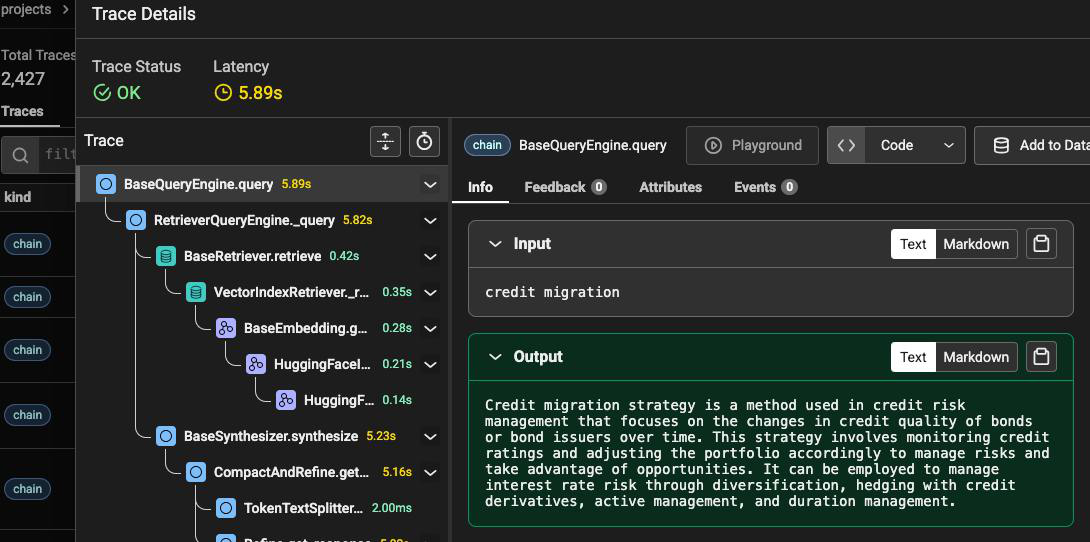

In [53]:
from PIL import Image
img_one = Image.open('images/img_1.jpeg')
display(img_one)

#### Query

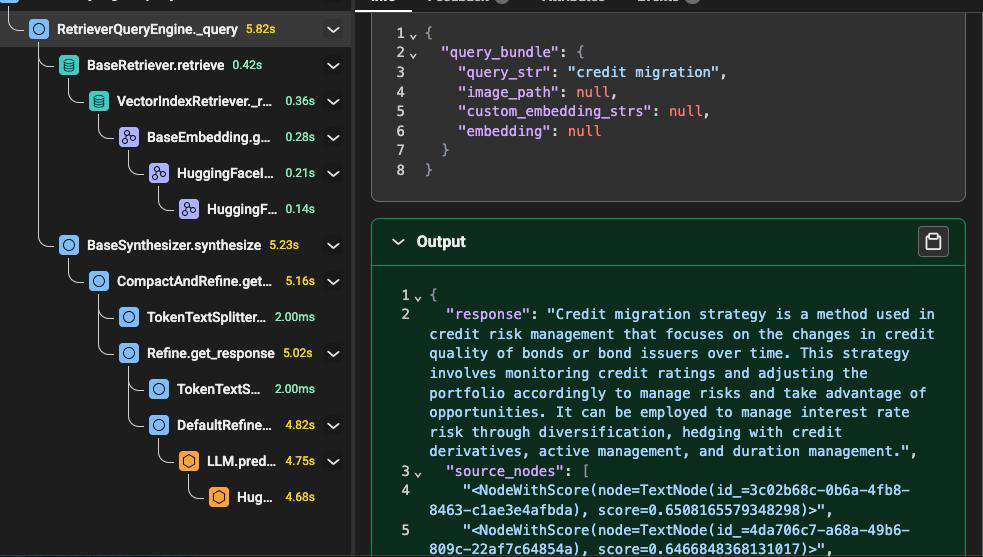

In [54]:
img_two = Image.open('images/img_2.jpeg')
display(img_two)

#### Retrieved Documents

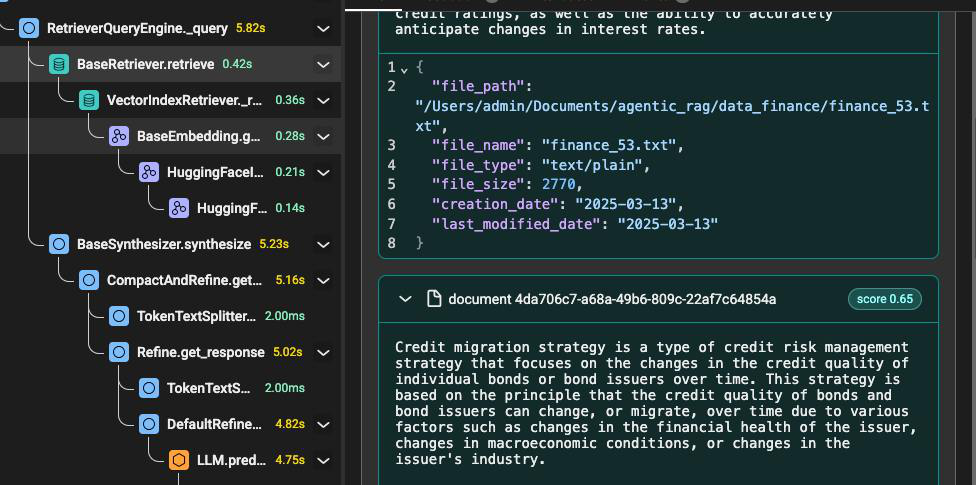

In [55]:
img_three = Image.open('images/img_3.jpeg')
display(img_three)